## Prepare Data

Get seasons wise kickers and pro bowl data

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import os
import json
import time
import pickle
import requests

%matplotlib inline

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
CONFIG = {
    'user': 'db_gtown_2018',
    'password': 'Gtown2018',
    'port': '3306',
    'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
    'database': 'db_nfl',
    'raise_on_warnings': True,
}

QUERY = """SELECT 
        FKICKER,COND,SURF,      
        Percentage.GID,
        GAME.SEAS AS SEASON,
        ((SUM(SUCCESS) / COUNT(*)) * 100) AS SUCCESS_PRCNTG,
        ((SUM(BLOCKED) / COUNT(*)) * 100) AS BLOCKED_PRCNTG,
        COUNT(*) AS PLAY_COUNT,
        CASE
            WHEN SUM(HIGH_PRESSURE) = 0 THEN 0
            ELSE ((SUM(HIGH_PRESSURE_SUCCESS) / SUM(HIGH_PRESSURE)) * 100)
        END AS HIGH_PRESSURE_SUCCESS_PRCNTG,
        SUM(HIGH_PRESSURE) AS HIGH_PRESSURE_COUNT,
        CASE
            WHEN SUM(LONG_DIST) = 0 THEN 0
            ELSE ((SUM(LONG_DIST_SUCCESS) / SUM(LONG_DIST)) * 100)
        END AS LONG_DIST_SUCCESS_PRCNTG, 
        SUM(LONG_DIST) AS LONG_DIST_COUNT,
        TEMP,
        HUMD,
        WSPD,
        (YEAR(CURDATE()) - PLAYER.start) AS YEARS_PLAYED,
        height,
        weight,
        PLAYER.forty,
        PLAYER.bench,
        PLAYER.vertical,
        PLAYER.broad,
        PLAYER.shuttle,
        PLAYER.cone,
        PLAYER.arm,
        PLAYER.hand,
        PLAYER.dcp,
        DPOS AS DRAFT_POSITION,
        (SELECT 
                (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
            FROM
                db_nfl.PLAYER P
            WHERE
                P.player = FKICKER) AS AGE_YEARS,
        CASE WHEN PRO_BOWL.ProBowl_Level IS NULL THEN 0 ELSE 1 END AS INPROBOWLTEAM
    FROM
        (SELECT 
            FGXP,
                PBP.GID,
                PBP.FKICKER,
                CASE
                    WHEN GOOD = 'Y' THEN 1
                    ELSE 0
                END AS SUCCESS,
                CASE
                    WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                    ELSE 0
                END AS BLOCKED,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                            AND GOOD = 'Y'
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE_SUCCESS,
                CASE
                    WHEN DIST >= 50 THEN 1
                    ELSE 0
                END AS LONG_DIST,
                CASE
                    WHEN DIST >= 50 AND GOOD = 'Y' THEN 1
                    ELSE 0
                END AS LONG_DIST_SUCCESS,
                DIST - (100 - CASE
                    WHEN YFOG = '' THEN '98'
                    ELSE YFOG
                END) AS YDS_BEHIND_LOS
        FROM
            db_nfl.PBP
        LEFT OUTER JOIN db_nfl.PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
        WHERE POS1 = 'K' ) AS Percentage
            LEFT OUTER JOIN
        db_nfl.PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
            LEFT OUTER JOIN
        db_nfl.GAME ON Percentage.GID = GAME.GID 
        LEFT OUTER JOIN
        db_nfl.PRO_BOWL ON PRO_BOWL.PLAYER_ID = PLAYER.PLAYER AND GAME.SEAS = ProBowl_Year        
    GROUP BY FKICKER , GAME.SEAS
    ORDER BY FKICKER , GAME.SEAS;"""

FEATURES = ['FKICKER','COND','SURF','GID','SEASON','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
        'HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT',
        'TEMP','HUMD','WSPD', 
        'YEARS_PLAYED','height','weight','forty','bench',
        'vertical','broad','shuttle','cone',
        'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS','INPROBOWLTEAM']

def fetch_data():   
    try:
        cnx = mysql.connector.connect(**CONFIG)
        cursor = cnx.cursor()
        #Let's read all the rows in the table
        cursor.execute(QUERY)
        #specify the attributes that you want to display
        df = DataFrame(cursor.fetchall())    
        df.columns = FEATURES
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()
DATA = fetch_data()     

In [3]:
DATA.head(3)

,FKICKER,COND,SURF,GID,SEASON,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,HIGH_PRESSURE_COUNT,...,vertical,broad,shuttle,cone,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS,INPROBOWLTEAM
0,AD-0800,Mostly Cloudy,AstroTurf,14,2000,86.8421,2.6316,76,73.6842,19,...,0.0,0,0.0,0.0,0,0.0,0,0,56.2795,0
1,AE-0700,Mostly Sunny,Grass,793,2003,89.1892,0.0000,74,94.4444,18,...,0.0,0,0.0,0.0,0,0.0,0,0,40.0219,0
2,AE-0700,Partly Cloudy,Grass,1054,2004,75.0000,0.0000,4,100.0000,1,...,0.0,0,0.0,0.0,0,0.0,0,0,40.0219,0


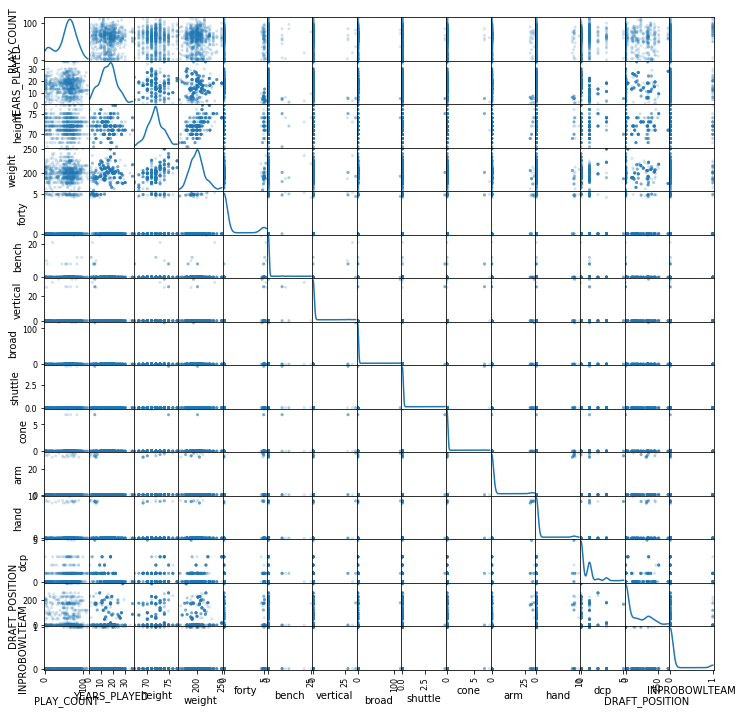

In [4]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(DATA, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

In [5]:
corr_matrix = DATA.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('shuttle', 'cone'), ('arm', 'hand')]

In [6]:
DATA.columns

Index(['FKICKER', 'COND', 'SURF', 'GID', 'SEASON', 'SUCCESS_PRCNTG',
       'BLOCKED_PRCNTG', 'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'HIGH_PRESSURE_COUNT', 'LONG_DIST_SUCCESS_PRCNTG', 'LONG_DIST_COUNT',
       'TEMP', 'HUMD', 'WSPD', 'YEARS_PLAYED', 'height', 'weight', 'forty',
       'bench', 'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand', 'dcp',
       'DRAFT_POSITION', 'AGE_YEARS', 'INPROBOWLTEAM'],
      dtype='object')

In [7]:
FEATURES_SELECTED = ['FKICKER','COND','SURF','GID','SEASON','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
        'HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT',         
        'YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle',
        'arm','dcp','DRAFT_POSITION','AGE_YEARS','INPROBOWLTEAM']
DATA=DATA[FEATURES_SELECTED]

## Handle Categorical Features

### Analyse Weather conditions

In [8]:
DATA["COND"].value_counts()

Sunny            171
Dome             101
Cloudy            86
Partly Cloudy     85
Closed Roof       60
Clear             56
Mostly Cloudy     39
Chance Rain       25
Mostly Sunny      21
Rain              16
                  14
Fair              11
Partly Sunny      10
Light Rain         9
Hazy               6
Foggy              1
Name: COND, dtype: int64

too many weather conditions, map these conditions to fewer categories

NORMAL_WEATHER     640
HARD_WEATHER        34
EXTREME_WEATHER     23
UNKNOWN_WEATHER     14
Name: COND, dtype: int64

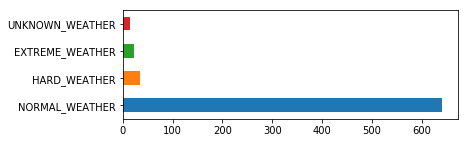

In [9]:
WeatherConditionsDifficultyLevel = {
    'NORMAL_WEATHER' :['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
                       'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
                       'Sunny','Mostly Sunny','Partly Sunny'],
    'HARD_WEATHER'   :['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'EXTREME_WEATHER':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
                     'Windy','Overcast']
}

def get_weather_category(dict, text):
    if(text==''):
        return 'UNKNOWN_WEATHER'
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
DATA["COND"] = DATA.apply(lambda row: get_weather_category(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
plt.figure(figsize=(6,2))
DATA["COND"].value_counts().plot(kind='barh')
DATA["COND"].value_counts()

Now let's create dummy column for each weather category

In [10]:
DATA=pd.concat([DATA,pd.get_dummies(DATA["COND"])], axis=1)

### Analyse SURF

In [11]:
DATA["SURF"].value_counts()

Grass                   427
FieldTurf               116
AstroTurf                87
MomentumTurf             21
UBU Speed Series S5M     19
DD GrassMaster           18
AstroPlay                13
A Turf Titan              6
Sportex                   3
SportGrass                1
Name: SURF, dtype: int64

Now let's create dummy column for each SURF type

In [12]:
DATA=pd.concat([DATA,pd.get_dummies(DATA["SURF"])], axis=1)

In [13]:
DATA.head(3)

,FKICKER,COND,SURF,GID,SEASON,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,HIGH_PRESSURE_COUNT,...,A Turf Titan,AstroPlay,AstroTurf,DD GrassMaster,FieldTurf,Grass,MomentumTurf,SportGrass,Sportex,UBU Speed Series S5M
0,AD-0800,NORMAL_WEATHER,AstroTurf,14,2000,86.8421,2.6316,76,73.6842,19,...,0,0,1,0,0,0,0,0,0,0
1,AE-0700,NORMAL_WEATHER,Grass,793,2003,89.1892,0.0000,74,94.4444,18,...,0,0,0,0,0,1,0,0,0,0
2,AE-0700,NORMAL_WEATHER,Grass,1054,2004,75.0000,0.0000,4,100.0000,1,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# get quantitaive features
dt = DATA.iloc[:,3:]
dt.apply(pd.to_numeric, errors='ignore')

#data for modeling , before 2017 data
dt_modeling = dt[dt['SEASON'] <2016]
dt_modeling_data = dt_modeling.iloc[:, 0:-1]
target_modeling = dt_modeling.iloc[:, -1]

#data for validate perdiction to validate over fitting of model - 2017 dta
dt_predict = dt[dt['SEASON'] >=2016]
dt_predict_data = dt_predict.iloc[:, 0:-1]
target_predict = dt_predict.iloc[:, -1]

In [37]:
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Identify our data and target 
X = dt_modeling_data
y = target_modeling

# Create random train and test splits
splits = tts(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

In [50]:
results=[]
names=[]

def fit_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start 
    score = model.score(X_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    #print(model.get_params()) 
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    #print(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
    


LogisticRegression fit in 0.01 seconds score: 0.9921
DecisionTreeClassifier fit in 0.00 seconds score: 1.0000
RandomForestClassifier fit in 0.01 seconds score: 0.9921
GaussianNB fit in 0.00 seconds score: 0.9921
SVC fit in 0.03 seconds score: 0.9921


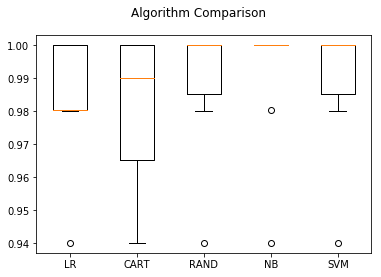

In [51]:
# prepare models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RAND', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

    
for name,model in models:
    fit_model(model)    
    
    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [57]:
X = dt_predict_data
y = target_predict
def predict_model(model):
    yhat = model.predict(dt_predict_data)
    #r2 = r2_score(target_predict, yhat)
    #me = mse(target_predict, yhat)
    #print("r2={:0.3f} MSE={:0.3f}".format(r2,me))
    print(classification_report(y, yhat))
for name, model in models:
    predict_model(model)  

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       626
          1       0.50      0.17      0.25         6

avg / total       0.99      0.99      0.99       632

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       626
          1       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00       632

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       626
          1       1.00      0.50      0.67         6

avg / total       1.00      1.00      0.99       632

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       626
          1       1.00      0.83      0.91         6

avg / total       1.00      1.00      1.00       632

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       626
          1       1.00      0.83 

LR


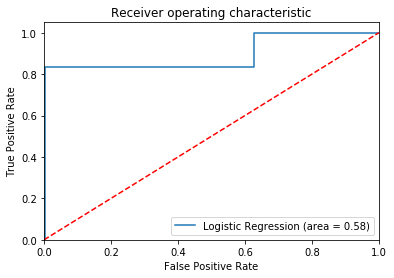

CART


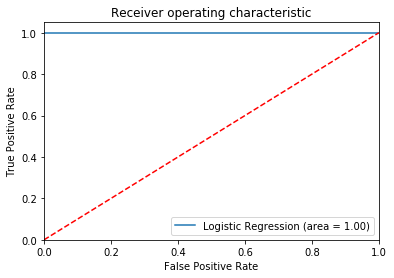

RAND


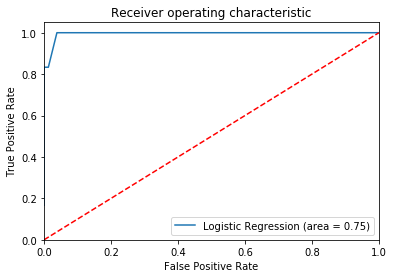

NB


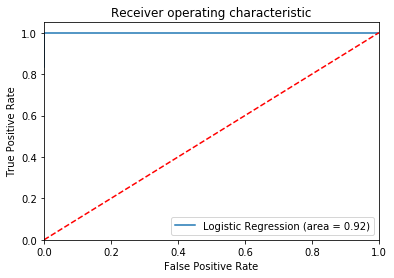

SVM


AttributeError: predict_proba is not available when  probability=False

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for name, model in models:
    print(name)
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()